# ffxiv Replication Power Analysis

Based off of code from J. Nathan Matias ([natematias.com](https://natematias.com)) ([@natematias](https://twitter.com/natematias))
Julia Kamin
May 2019

In [1]:
options("scipen"=9, "digits"=4)
library(dplyr)
library(MASS)           # contains fitdistr
library(ggplot2)        # for plotting 
library(rlang)
library(tidyverse)
library(viridis)        # colorblind safe palettes
library(DeclareDesign)
library(beepr)
## Installed DeclareDesign 0.13 using the following command:
# install.packages("DeclareDesign", dependencies = TRUE,
#                 repos = c("http://R.declaredesign.org", "https://cloud.r-project.org"))

## DOCUMENTATION AT: https://cran.r-project.org/web/packages/DeclareDesign/DeclareDesign.pdf
cbPalette <- c("#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")
options(repr.plot.width=7, repr.plot.height=3.5)
sessionInfo()


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘MASS’

The following object is masked from ‘package:dplyr’:

    select

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  1.4.2     ✔ purrr   0.2.5
✔ tidyr   0.8.2     ✔ stringr 1.3.1
✔ readr   1.2.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::%||%()        masks rlang::%||%()
✖ purrr::%@%()         masks rlang::%@%()
✖ purrr::as_function() masks rlang::as_function()
✖ dplyr::filter()      masks stats::filter()
✖ purrr::flatten()     masks rlang::flatten()
✖ purrr::flatten_chr() masks rlang::flatten_chr()
✖ purrr::flatten_dbl() masks rlang::flatten_dbl()
✖ purrr::flatten_int() masks rlang::flatten_int()
✖ purrr::flatten_lgl() masks rlang::flatten_lgl()
✖ purrr::inv

R version 3.5.1 (2018-07-02)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 16.04.5 LTS

Matrix products: default
BLAS: /usr/lib/libblas/libblas.so.3.6.0
LAPACK: /usr/lib/lapack/liblapack.so.3.6.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] beepr_1.3            DeclareDesign_0.12.0 estimatr_0.14       
 [4] fabricatr_0.6.0      randomizr_0.16.1     viridis_0.5.1       
 [7] viridisLite_0.3.0    forcats_0.3.0        stringr_1.3.1       
[10] purrr_0.2.5          readr_1.2.1          tidyr_0.8.2         
[13] tibble_1.4.2         tid

In [2]:
## the power-analysis-utils.R source file includes the following methods:
# mu.diff.from.mu.irr
# betas.logit.from.prob
# betas.logit.from.mean
# min.diagnosis.power
# iterate.for.power
# plot.power.results
source("../SOC412/power-analysis-utils.R")

# Step One: Analyze Current Dataset to Observe Control Group Characteristics

In this step, we use the `fitdistr` method from the `MASS` library to estimate the parameters of a negative binomial distribution describing the number of newcomer comments and the number of removed newcomer comments per discussion.

In [22]:
data.folder <- "/home/civilservant/Tresors/CivilServant/projects/CivilServant-reddit/replication-drive-2019/power-analysis/datasets"
# dataset from CivilServant production 
#post.filename <- "sticky_comment_power_analysis_2t7no_5.2018_3.2019_posts.csv"
#comment.filename <- "sticky_comment_power_analysis_2t7no_5.2018_3.2019_comments.csv"

# baumgartner dataset
post.filename <- "sticky_comment_power_analysis_2rgs7_12.2018_2.2019_posts.csv"
comment.filename <- "sticky_comment_power_analysis_2rgs7_12.2018_2.2019_comments.csv"

In [23]:
post.df <- read.csv(file.path(data.folder, post.filename))
comment.df <- read.csv(file.path(data.folder, comment.filename))

print(paste("Removing", 
            nrow(subset(post.df, is.na(num.comments) | is.na(num.comments.removed))),
            "posts with NA comments or NA num comments removed(usually auto-removed spam posts)"
))

post.df <- subset(post.df, is.na(num.comments)!=TRUE & is.na(num.comments.removed)!=TRUE)
# subsetting for time period between 1.28 and 2.25
post.df <- subset(post.df, as.Date(created.utc) > as.Date("2019-01-28") & as.Date(created.utc) < as.Date("2019-02-25"))
comment.df <- subset(comment.df, as.Date(created.utc) > as.Date("2019-01-28") & as.Date(created.utc) < as.Date("2019-02-25"))
print(paste("Total: ", nrow(post.df), "posts"))

[1] "Removing 3 posts with NA comments or NA num comments removed(usually auto-removed spam posts)"
[1] "Total:  4321 posts"


In [24]:
print(colnames(post.df))

 [1] "id"                        "created.utc"              
 [3] "author"                    "body.length"              
 [5] "weekday"                   "url"                      
 [7] "is.selftext"               "visible"                  
 [9] "num.comments"              "num.comments.removed"     
[11] "newcomer.comments"         "newcomer.comments.removed"
[13] "front_page"                "author.prev.posts"        
[15] "author.prev.participation" "flair"                    


In [25]:
## ADD DATES TO COMMENTS AND POSTS
post.df$created <- as.Date(post.df$created.utc)
comment.df$created <- as.Date(comment.df$created.utc)
total.days <- as.integer(max(post.df$created) - min(post.df$created))

In [26]:
print(paste("Posts Min date:", min(post.df$created), ", Max date:", max(post.df$created)))
print(paste("Posts per day", as.integer(nrow(post.df) / total.days)))
print(paste("Comments Min date:", min(comment.df$created), ", Max date:", max(comment.df$created)))
print(paste("Mean Comments per post", as.integer(mean(post.df$num.comments))))
print(paste("Mean Newcomer Comments per post", as.integer(mean(post.df$newcomer.comments))))
print(paste("Mean Newcomer Comments removed per post", as.integer(mean(post.df$newcomer.comments.removed))))

[1] "Posts Min date: 2019-01-29 , Max date: 2019-02-24"
[1] "Posts per day 166"
[1] "Comments Min date: 2019-01-29 , Max date: 2019-02-24"
[1] "Mean Comments per post 29"
[1] "Mean Newcomer Comments per post 1"
[1] "Mean Newcomer Comments removed per post 0"


In [27]:
print(paste("Mean Comments Visible", mean(comment.df$visible=="False", na.rm=TRUE)))
print(paste("Num Newcomer Comments", nrow(subset(comment.df, author.prev.comments==0))))
print(paste("Num Newcomer Comments / Day:", as.integer(nrow(subset(comment.df, author.prev.comments==0)) / total.days)))
print(paste("Num Newcomer Comments Removed / Day:", as.integer(nrow(subset(comment.df, author.prev.comments==0 & visible=="False")) / total.days)))
print(paste("% Newcomer Comments Removed:", nrow(subset(comment.df, author.prev.comments == 0 & visible=="False")) / nrow(subset(comment.df, author.prev.comments == 0 ))*100))

[1] "Mean Comments Visible 0.00736818778986023"
[1] "Num Newcomer Comments 5395"
[1] "Num Newcomer Comments / Day: 207"
[1] "Num Newcomer Comments Removed / Day: 0"
[1] "% Newcomer Comments Removed: 0"


In [28]:
print(paste("Mean Comments Per Day", nrow(comment.df) / total.days))
print(paste("Mean Comments Removed / Day:", as.integer(nrow(subset(comment.df, visible=="False")) / total.days)))


[1] "Mean Comments Per Day 4859.76923076923"
[1] "Mean Comments Removed / Day: 35"


In [34]:
print(paste("% Comments Removed:", (nrow(subset(comment.df, visible=="False")) / nrow(comment.df))*100))

[1] "% Comments Removed: 0.736818778986023"


In [40]:
summary(post.df$num.comments > 0)

   Mode   FALSE    TRUE 
logical     278    4043 

In [43]:
#summary(post.df$visible)

In [95]:
print(paste("Posts Min date:", min(post.df$created), ", Max date:", max(post.df$created)))
print(paste("Posts per day", as.integer(nrow(post.df) / total.days)))
print(paste("Comments Min date:", min(comment.df$created), ", Max date:", max(comment.df$created)))
print(paste("Mean Comments per post", as.integer(mean(post.df$num.comments))))
print(paste("Mean Newcomer Comments per post", as.integer(mean(post.df$newcomer.comments))))
print(paste("Mean Newcomer Comments removed per post", as.integer(mean(post.df$newcomer.comments.removed))))

print(paste("Mean Comments Visible", mean(comment.df$visible=="False", na.rm=TRUE)))
print(paste("Num Newcomer Comments", nrow(subset(comment.df, author.prev.comments==0))))
print(paste("Num Newcomer Comments / Day:", as.integer(nrow(subset(comment.df, author.prev.comments==0)) / total.days)))
print(paste("Num Newcomer Comments Removed / Day:", as.integer(nrow(subset(comment.df, author.prev.comments==0 & visible=="False")) / total.days)))
print(paste("% Newcomer Comments Removed:", nrow(subset(comment.df, author.prev.comments == 0 & visible=="False")) / nrow(subset(comment.df, author.prev.comments == 0 ))*100))

print("")
print(paste("Mean Comments Per Day", nrow(comment.df) / total.days))
print(paste("Mean Comments Removed / Day:", as.integer(nrow(subset(comment.df, visible=="False")) / total.days)))
print(paste("% Comments Removed:", nrow(subset(comment.df, visible=="False")) / nrow(comment.df)*100))

[1] "Posts Min date: 2019-01-29 , Max date: 2019-02-24"
[1] "Posts per day 166"
[1] "Comments Min date: 2019-01-29 , Max date: 2019-02-24"
[1] "Mean Comments per post 29"
[1] "Mean Newcomer Comments per post 1"
[1] "Mean Newcomer Comments removed per post 0"
[1] "Mean Comments Visible 0.00736818778986023"
[1] "Num Newcomer Comments 5395"
[1] "Num Newcomer Comments / Day: 207"
[1] "Num Newcomer Comments Removed / Day: 0"
[1] "% Newcomer Comments Removed: 0"
[1] ""
[1] "Mean Comments Per Day 4859.76923076923"
[1] "Mean Comments Removed / Day: 35"
[1] "% Comments Removed: 0.736818778986023"


Estimate stuff

In [108]:
print("Newcomer Comments")
print(summary(post.df$newcomer.comments))
nc.dist <- fitdistr(post.df$newcomer.comments, densfun="negative binomial")
## newcomer comments removed
#print("Num Newcomer Comments Removed")
#print(summary(post.df$newcomer.comments.removed))
#ncr.dist <- fitdistr(post.df$newcomer.comments.removed, densfun="negative binomial")
## comments removed
print("Num Comments Removed")
print(summary(post.df$num.comments.removed))
cr.dist <- fitdistr(post.df$num.comments.removed, densfun="negative binomial")
## all comments
print("Num Total Comments")
print(summary(post.df$num.comments))
c.dist <- fitdistr(post.df$num.comments, densfun="negative binomial")

[1] "Newcomer Comments"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0     0.0     0.0     1.2     1.0   332.0 


Warning message in densfun(x, parm[1], parm[2], ...):
“NaNs produced”Warning message in densfun(x, parm[1], parm[2], ...):
“NaNs produced”Warning message in densfun(x, parm[1], parm[2], ...):
“NaNs produced”Warning message in densfun(x, parm[1], parm[2], ...):
“NaNs produced”Warning message in densfun(x, parm[1], parm[2], ...):
“NaNs produced”Warning message in densfun(x, parm[1], parm[2], ...):
“NaNs produced”Warning message in densfun(x, parm[1], parm[2], ...):
“NaNs produced”Warning message in densfun(x, parm[1], parm[2], ...):
“NaNs produced”Warning message in densfun(x, parm[1], parm[2], ...):
“NaNs produced”Warning message in densfun(x, parm[1], parm[2], ...):
“NaNs produced”

[1] "Num Comments Removed"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    0.00    0.00    0.21    0.00   83.00 


Warning message in densfun(x, parm[1], parm[2], ...):
“NaNs produced”Warning message in densfun(x, parm[1], parm[2], ...):
“NaNs produced”Warning message in densfun(x, parm[1], parm[2], ...):
“NaNs produced”Warning message in densfun(x, parm[1], parm[2], ...):
“NaNs produced”Warning message in densfun(x, parm[1], parm[2], ...):
“NaNs produced”Warning message in densfun(x, parm[1], parm[2], ...):
“NaNs produced”Warning message in densfun(x, parm[1], parm[2], ...):
“NaNs produced”Warning message in densfun(x, parm[1], parm[2], ...):
“NaNs produced”Warning message in densfun(x, parm[1], parm[2], ...):
“NaNs produced”

[1] "Num Total Comments"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0     3.0     8.0    29.1    21.0  2986.0 


In [65]:
exp(0.14)

[1] 1.15

### Experiment Configuration

In [86]:
count.config <- data.frame(
    pa.label = "ffxiv.design",
    n.max = 35000,
    n.min = 2500,
    
    NC.mu    = nc.dist$estimate[['mu']],
    NC.theta = nc.dist$estimate[['size']],
    NC.effect.irr = exp(0.14), # 15% increase <- you may want to adjust this

    # since no newcomer comments were removed, not using NCR for now
    #NCR.mu    = ncr.dist$estimate[['mu']],
    #NCR.theta = ncr.dist$estimate[['size']],
    #NCR.effect.irr = exp(-0.16251) # 0.85x, a 15% decrease <- you may decide to adjust this
    
    # using all comments removed instead
    CR.mu    = cr.dist$estimate[['mu']],
    CR.theta = cr.dist$estimate[['size']],
    CR.effect.irr = exp(-0.14) # 0.85x, a 15% decrease <- you may decide to adjust this
)

In [87]:
diagnose.experiment  <- function( n.size, cdf, sims.count = 500, bootstrap.sims.count = 500){
    design <-   declare_population(N = n.size) +
            declare_potential_outcomes(
                # num newcomer comments
                NC_Z_0 = rnegbin(n=N, mu = cdf$NC.mu, 
                                 theta = cdf$NC.theta),
                NC_Z_1 = rnegbin(n=N, mu =  cdf$NC.mu + mu.diff.from.mu.irr(
                                                cdf$NC.mu,
                                                cdf$NC.effect.irr),
                                 theta = cdf$NC.theta),
                
                # not using since no newcomer comments removed
                #NCR_Z_0 = rnegbin(n=N, mu = cdf$NCR.mu, 
                #                 theta = cdf$NCR.theta),
                #NCR_Z_1 = rnegbin(n=N, mu = cdf$NCR.mu +  mu.diff.from.mu.irr(
                #                                cdf$NCR.mu,
                #                                cdf$NCR.effect.irr),
                #                 theta = cdf$NCR.theta)
                
                # using comments removed instead
                CR_Z_0 = rnegbin(n=N, mu = cdf$CR.mu, 
                                 theta = cdf$CR.theta),
                CR_Z_1 = rnegbin(n=N, mu = cdf$CR.mu +  mu.diff.from.mu.irr(
                                                cdf$CR.mu,
                                                cdf$CR.effect.irr),
                                 theta = cdf$CR.theta)
            ) +
            declare_assignment(num_arms = 2,
                               conditions = (c("0", "1"))) +
            declare_estimand(ate_NC_1_0  = log(cdf$NC.effect.irr)) +
            declare_estimand(ate_CR_1_0  = log(cdf$CR.effect.irr)) +
            declare_reveal(outcome_variables = c("NC", "CR"))  +
    
            ##
            ## ESTIMATORS FOR NC
            ## 

            ## Estimator: Negative Binomial Regression
            ## this is how a custom estimator is defined. 
            ## in this case, it runs glm.nb, records the coefficient & test statistics
            ## for the term "Z1" in the summary table, calculates confidence intervalss
            ## and returns the outcome along with confidence intervals
            declare_estimator(handler=tidy_estimator(function(data){
                                  m <- glm.nb(formula = NC ~ Z, data)
                                  out <- subset(tidy(m), term == "Z1")
                                  transform(out,
                                      conf.low = estimate - 1.96*std.error,
                                      conf.high = estimate + 1.96*std.error
                                  )
                              }), estimand="ate_NC_1_0", label="NC.nb 1/0") +

            ##
            ## ESTIMATORS FOR CR
            ## 

            ## Estimator: Negative Binomial Regression NOT USING SINCE NO NEWCOMER COMMENTS REMOVED

            declare_estimator(handler=tidy_estimator(function(data){
                                  m <- glm.nb(formula = CR ~ Z, data)
                                  out <- subset(tidy(m), term == "Z1")
                                  transform(out,
                                      conf.low = estimate - 1.96*std.error,
                                      conf.high = estimate + 1.96*std.error
                                  )
                              }), estimand="ate_CR_1_0", label="CR.nb 1/0")
    
    diagnosis <- diagnose_design(design, sims = sims.count, 
                                 bootstrap_sims = bootstrap.sims.count)
    diagnosis
}

# Conduct Power Analysis (Posts)

In [88]:
interval = 2500
power.iterate.df <- iterate.for.power(count.config, 
                                      diagnosis.method=diagnose.experiment, 
                                      iteration.interval = interval)
# beep(sound="treasure")

[1] "min: 2500 max: 35000 current: 2500"
[1] "     seconds: 41"
[1] "min: 2500 max: 35000 current: 5000"
[1] "     seconds: 69"
[1] "min: 2500 max: 35000 current: 7500"
[1] "     seconds: 99"
[1] "min: 2500 max: 35000 current: 10000"
[1] "     seconds: 131"
[1] "min: 2500 max: 35000 current: 12500"
[1] "     seconds: 163"
[1] "min: 2500 max: 35000 current: 15000"
[1] "     seconds: 196"
[1] "min: 2500 max: 35000 current: 17500"
[1] "     seconds: 228"
[1] "min: 2500 max: 35000 current: 20000"
[1] "     seconds: 260"
[1] "min: 2500 max: 35000 current: 22500"
[1] "     seconds: 291"
[1] "min: 2500 max: 35000 current: 25000"
[1] "     seconds: 359"
[1] "min: 2500 max: 35000 current: 30000"
[1] "     seconds: 390"
[1] "min: 2500 max: 35000 current: 32500"
[1] "     seconds: 425"
[1] "min: 2500 max: 35000 current: 35000"
[1] "     seconds: 459"


## Diagnose Post Power Analysis 
### Statistical Power Associated with Estimators

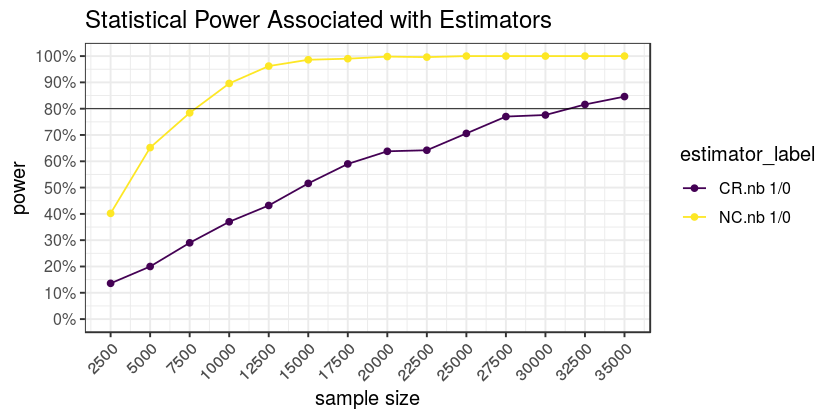

In [89]:
ggplot(power.iterate.df, aes(n, power, color=estimator_label)) +
    ## CHART SUBSTANCE
    geom_line() +
    geom_point() +
    ## LABELS AND COSMETICS
    geom_hline(yintercept=0.8, size=0.25) +
    theme_bw(base_size = 12, base_family = "Helvetica") +
    theme(axis.text.x = element_text(angle=45, hjust = 1)) +
    scale_y_continuous(breaks = seq(0,1,0.1), limits = c(0,1), labels=scales::percent) +
    scale_x_continuous(breaks = seq(count.config$n.min,count.config$n.max,interval)) +
    scale_color_viridis(discrete=TRUE) +
    xlab("sample size") +
    ggtitle("Statistical Power Associated with Estimators")

# Diagnose Comment Power Analysis - Newcomers
In this case, we assign comments to discussions and treat the discussions. Here, we need to specify a distribution of cluster sizes

In [103]:
comment.config <- data.frame(
    pa.label = "comment.design",
#    n.max = 12100,
    n.max = 7000,
    n.min = 3000,

    NC.mu    = nc.dist$estimate[['mu']],
    NC.theta = nc.dist$estimate[['size']],
    NC.effect.irr = exp(0.1397), # 15% increase <- you may want to adjust this

    # whether comment is visible
    ACT.ctl      = 0.9926,    ## the control group probability of taking an action 
    ACT.effect.a = 0.0037    ## the increase in the probability of taking action A
)

In [104]:
# tutorial on specifying clusters of different sizes here:
# https://declaredesign.org/r/estimatr/articles/simulations-debiasing-dim.html

## here, n is the number of discussions

diagnose.experiment.binary  <- function( n.size, cdf, sims.count = 500, bootstrap.sims.count = 500){
    design <-   declare_population(
                    # clusters are posts
                    clusters = add_level(
                        N = n.size,
                        # we add one, since declare_population can't handle empty clusters
                        # this adds bias into our power analysis
                        individs_per_clust = rnegbin(n=n.size, mu = cdf$NC.mu, theta = cdf$NC.theta)+1,
                        condition_pr = 0.5
                    ),
                    individual = add_level(
                          N = individs_per_clust,
                          epsilon = rnorm(N, sd = 3)  #add an error term for individuals within clusters
                    )
                ) +
            ## these potential outcome definitions may be incorrect
            declare_potential_outcomes(
                ACT_Z_0 = rbinom(N, 1, cdf$ACT.ctl),
                ACT_Z_1 = rbinom(N, 1, cdf$ACT.ctl + cdf$ACT.effect.a)
            ) +
            declare_assignment(clusters = clusters, prob = 0.5) +
            declare_estimand(ate_ACT_mean_1_0  = cdf$ACT.effect.a) +
            declare_reveal(outcome_variables = c("ACT"), assignment_variables = c("Z")) +
            declare_estimator(formula = ACT ~ Z,
                              clusters = clusters,
                              label = "ACT_mean_1_0")

     diagnosis <- diagnose_design(design, sims = sims.count, 
                                  bootstrap_sims = bootstrap.sims.count)
     diagnosis
}

In [105]:
interval = 500
comment.iterate.df <- iterate.for.power(comment.config, 
                                      diagnosis.method=diagnose.experiment.binary, 
                                      iteration.interval = interval)
# beep(sound="treasure")

[1] "min: 3000 max: 7000 current: 3000"
[1] "     seconds: 242"
[1] "min: 3000 max: 7000 current: 3500"
[1] "     seconds: 325"
[1] "min: 3000 max: 7000 current: 4000"
[1] "     seconds: 426"
[1] "min: 3000 max: 7000 current: 4500"
[1] "     seconds: 534"
[1] "min: 3000 max: 7000 current: 5000"
[1] "     seconds: 661"
[1] "min: 3000 max: 7000 current: 5500"
[1] "     seconds: 796"
[1] "min: 3000 max: 7000 current: 6000"
[1] "     seconds: 950"
[1] "min: 3000 max: 7000 current: 6500"
[1] "     seconds: 1114"
[1] "min: 3000 max: 7000 current: 7000"
[1] "     seconds: 1302"


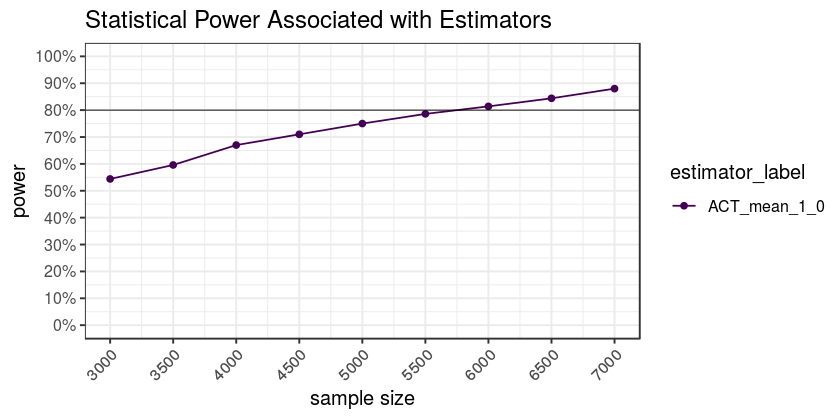

In [106]:
ggplot(comment.iterate.df, aes(n, power, color=estimator_label)) +
    ## CHART SUBSTANCE
    geom_line() +
    geom_point() +
    ## LABELS AND COSMETICS
    geom_hline(yintercept=0.8, size=0.25) +
    theme_bw(base_size = 12, base_family = "Helvetica") +
    theme(axis.text.x = element_text(angle=45, hjust = 1)) +
    scale_y_continuous(breaks = seq(0,1,0.1), limits = c(0,1), labels=scales::percent) +
    scale_x_continuous(breaks = seq(comment.config$n.min,comment.config$n.max,interval)) +
    scale_color_viridis(discrete=TRUE) +
    xlab("sample size") +
    ggtitle("Statistical Power Associated with Estimators")

# Diagnose Comment Power Analysis - All users
In this case, we assign comments to discussions and treat the discussions. Here, we need to specify a distribution of cluster sizes

In [121]:
comment.config <- data.frame(
    pa.label = "comment.design",
#    n.max = 12100,
    n.max = 3000,
    n.min = 500,

    C.mu    = c.dist$estimate[['mu']],
    C.theta = c.dist$estimate[['size']],
    C.effect.irr = exp(0.1397), # 15% increase <- you may want to adjust this

    # whether comment is visible
    ACT.ctl      = 0.9926,    ## the control group probability of taking an action 
    ACT.effect.a = 0.0018    ## the increase in the probability of taking action A
)

In [122]:
# tutorial on specifying clusters of different sizes here:
# https://declaredesign.org/r/estimatr/articles/simulations-debiasing-dim.html

## here, n is the number of discussions

diagnose.experiment.binary  <- function( n.size, cdf, sims.count = 500, bootstrap.sims.count = 500){
    design <-   declare_population(
                    # clusters are posts
                    clusters = add_level(
                        N = n.size,
                        # we add one, since declare_population can't handle empty clusters
                        # this adds bias into our power analysis
                        individs_per_clust = rnegbin(n=n.size, mu = cdf$C.mu, theta = cdf$C.theta)+1,
                        condition_pr = 0.5
                    ),
                    individual = add_level(
                          N = individs_per_clust,
                          epsilon = rnorm(N, sd = 3)  #add an error term for individuals within clusters
                    )
                ) +
            ## these potential outcome definitions may be incorrect
            declare_potential_outcomes(
                ACT_Z_0 = rbinom(N, 1, cdf$ACT.ctl),
                ACT_Z_1 = rbinom(N, 1, cdf$ACT.ctl + cdf$ACT.effect.a)
            ) +
            declare_assignment(clusters = clusters, prob = 0.5) +
            declare_estimand(ate_ACT_mean_1_0  = cdf$ACT.effect.a) +
            declare_reveal(outcome_variables = c("ACT"), assignment_variables = c("Z")) +
            declare_estimator(formula = ACT ~ Z,
                              clusters = clusters,
                              label = "ACT_mean_1_0")

     diagnosis <- diagnose_design(design, sims = sims.count, 
                                  bootstrap_sims = bootstrap.sims.count)
     diagnosis
}

In [123]:
interval = 500
comment.iterate.df <- iterate.for.power(comment.config, 
                                      diagnosis.method=diagnose.experiment.binary, 
                                      iteration.interval = interval)
# beep(sound="treasure")

[1] "min: 500 max: 3000 current: 500"
[1] "     seconds: 112"
[1] "min: 500 max: 3000 current: 1000"
[1] "     seconds: 218"
[1] "min: 500 max: 3000 current: 1500"
[1] "     seconds: 347"
[1] "min: 500 max: 3000 current: 2000"
[1] "     seconds: 507"
[1] "min: 500 max: 3000 current: 2500"
[1] "     seconds: 669"
[1] "min: 500 max: 3000 current: 3000"
[1] "     seconds: 851"


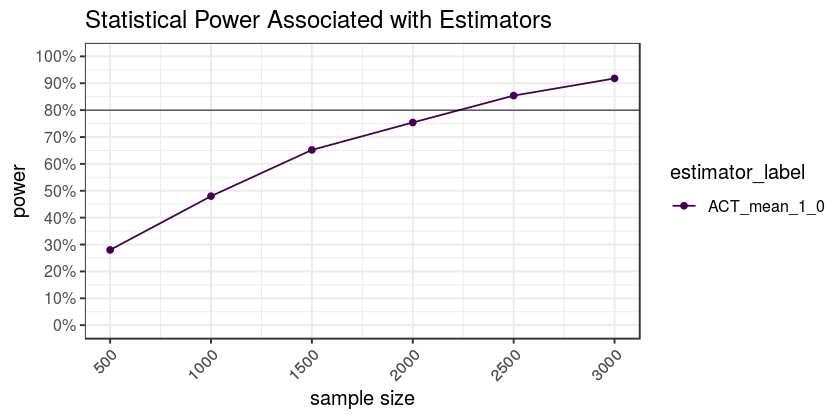

In [124]:
ggplot(comment.iterate.df, aes(n, power, color=estimator_label)) +
    ## CHART SUBSTANCE
    geom_line() +
    geom_point() +
    ## LABELS AND COSMETICS
    geom_hline(yintercept=0.8, size=0.25) +
    theme_bw(base_size = 12, base_family = "Helvetica") +
    theme(axis.text.x = element_text(angle=45, hjust = 1)) +
    scale_y_continuous(breaks = seq(0,1,0.1), limits = c(0,1), labels=scales::percent) +
    scale_x_continuous(breaks = seq(comment.config$n.min,comment.config$n.max,interval)) +
    scale_color_viridis(discrete=TRUE) +
    xlab("sample size") +
    ggtitle("Statistical Power Associated with Estimators")